<a href="https://colab.research.google.com/github/priyal6/ML/blob/main/HEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime')

In [ ]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [ ]:
color_pal = sns.color_palette()

In [ ]:
df.index = pd.to_datetime(df.index)

<Axes: xlabel='Datetime'>

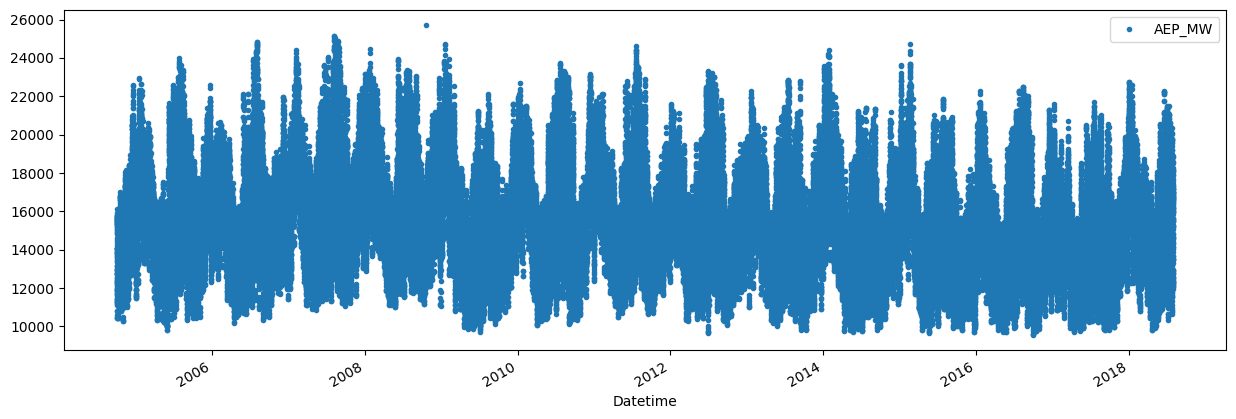

In [ ]:
df.plot(style='.',figsize=(15,5),color = color_pal[0])

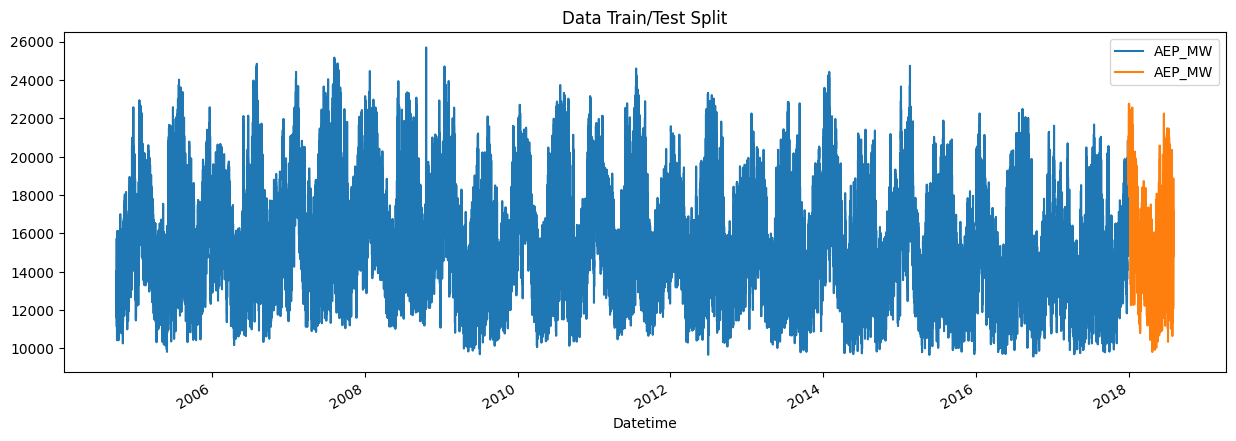

In [ ]:
train = df.loc[df.index < '01-01-2018']
test = df.loc[df.index >= '01-01-2018']

fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
plt.show()

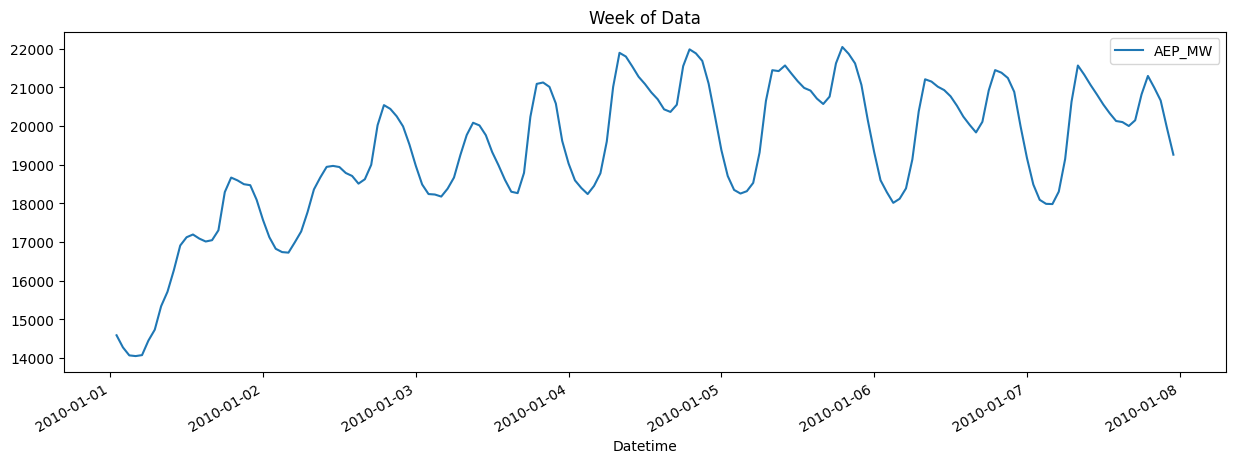

In [ ]:
df.loc[(df.index > '01-01-2010') & (df.index <'01-08-2010')].plot(figsize=(15,5),title='Week of Data')
plt.show()

In [ ]:
def create_features(df):
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week
  return df

df = create_features(df)

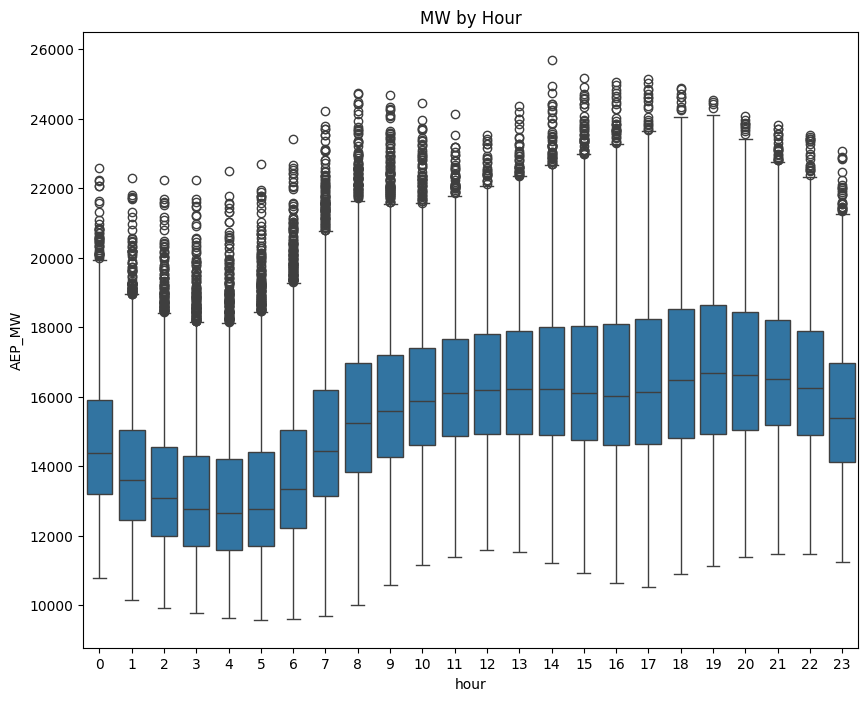

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y ='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

<ipython-input-11-ade4f92f54db>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x='month', y ='AEP_MW', palette='YlOrBr')


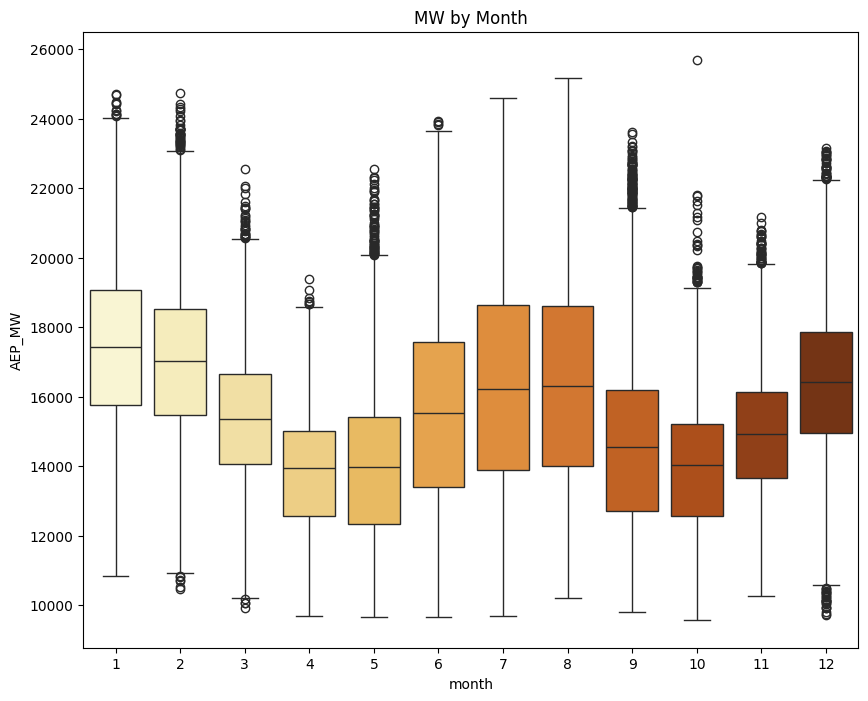

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='month', y ='AEP_MW', palette='YlOrBr')
ax.set_title('MW by Month')
plt.show()

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek',  'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score = 0.5, booster='gbtree',
                    n_estimators=1000,
                    early_stopping_rounds=50,
                    objective='reg:linear',
                    max_depth=3,
                    learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:15568.94793	validation_1-rmse:15342.07278


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5964.48494	validation_1-rmse:5830.55296
[200]	validation_0-rmse:2706.31843	validation_1-rmse:2807.48235
[300]	validation_0-rmse:1782.09707	validation_1-rmse:2023.65693
[400]	validation_0-rmse:1548.50967	validation_1-rmse:1824.02917
[500]	validation_0-rmse:1467.95422	validation_1-rmse:1780.48746
[600]	validation_0-rmse:1426.45124	validation_1-rmse:1766.91706
[690]	validation_0-rmse:1400.35136	validation_1-rmse:1767.73590


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [19]:
fi = pd.DataFrame(reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance']).sort_values('importance')

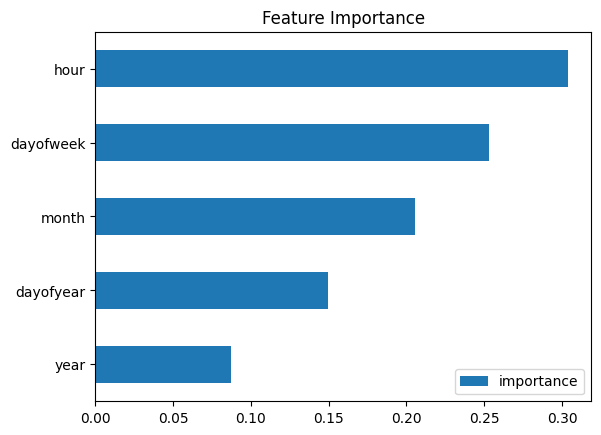

In [22]:
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()

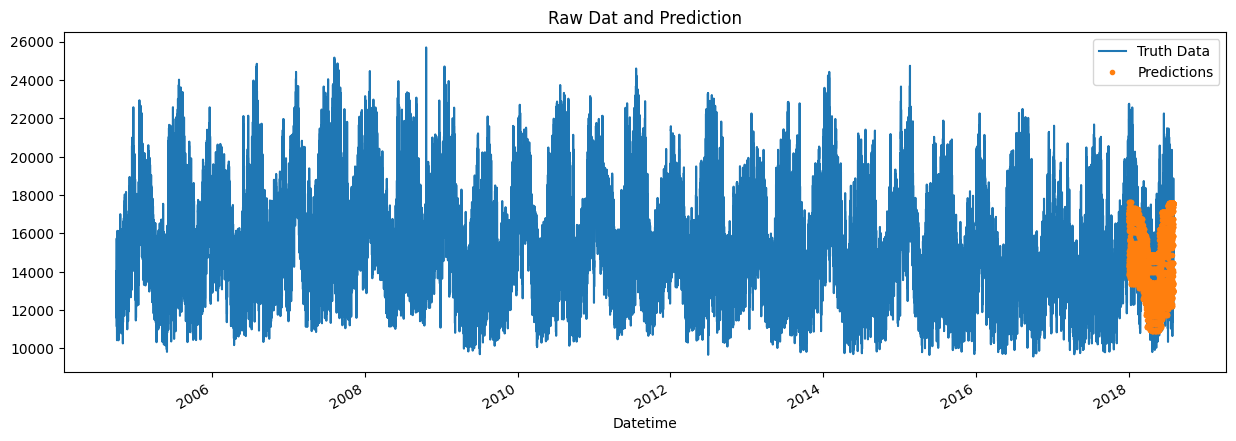

In [33]:
# Rename the 'prediction' column in either 'test' or 'df' before merging
test.rename(columns={'prediction': 'prediction_test'}, inplace=True)  # Renaming in 'test'

df = df.merge(test[['prediction_test']], how='left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction_test'].plot(ax=ax, style='.')  # Use the new column name
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [36]:
score =  np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction_test']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1762.57


In [40]:
test['error'] = np.abs(test[TARGET] - test['prediction_test'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

,error
date,
2018-04-15,149.493571
2018-02-10,239.282715
2018-05-18,315.500326
2018-04-14,379.050618
2018-05-16,412.096354


In [39]:
test.groupby(['date'])['error'].mean()

,error
date,
2018-01-01,3563.862142
2018-01-02,4969.296875
2018-01-03,4353.981405
2018-01-04,4131.939738
2018-01-05,4832.822550
...,...
2018-07-30,746.745931
2018-07-31,781.000529
2018-08-01,818.292196
